# import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
#
matplotlib.rcParams['text.usetex'] = True
warnings.filterwarnings('ignore')
#
#path = '../testRuns/test2nd/Run0/' #--- comment if passed by argument

# input stress file

In [124]:
def GetOrthogonalBasis( CellVector ): 
    a0 = CellVector[:,0]
    l0 = np.dot(a0,a0)**0.5
    n0 = a0 / l0 
    #
    a1 = CellVector[:,1]
    a1_perp = a1 - np.dot( a1, n0 ) * n0
    l1 = np.dot( a1_perp, a1_perp) ** 0.5
    #
    a2 = CellVector[:,2]
    l2 = np.dot(a2,a2)**0.5
    
    return np.c_[a0, a1_perp, a2], [l0, l1, l2]

def GetCordsTimeStep(slist):
    slist.readline()
    itime = int( slist.readline().split()[0] )
    
    [slist.readline() for i in xrange(1)]
    nrows = int(slist.readline().split()[0])

    [slist.readline() for i in xrange(1)]
    
    CellVector = np.array([slist.readline().split() for i in xrange( 3 )])
    
    cols = slist.readline().split()[2:]
    
    return np.array([slist.readline().split() for i in xrange( nrows )]), CellVector, itime, cols
    
def GetCords( file_name ):
    slist = open( file_name )    
    coord_atoms_broken = {}
    CellVector = {}
    try:
        while True:
            sarr, cell_vector, itime, cols  = GetCordsTimeStep( slist ) #--- get coord
            #--- insert in a data frame
            coord_atoms_broken[ itime ] = pd.DataFrame( sarr, columns = cols )
            
            #--- cast id to 'int'
            coord_atoms_broken[ itime ]['id'] = map(int,coord_atoms_broken[ itime ]['id'].tolist())[:]

            #--- sort
            coord_atoms_broken[ itime ].sort_values( by = 'id', inplace = True )
            
            #--- reset index
            coord_atoms_broken[ itime ].reset_index( drop=True, inplace=True )
            
            CellVector[ itime ] = cell_vector
    except:
#        traceback.print_exc()
        pass

    
    return coord_atoms_broken, CellVector

def GetCellVector( CellVector ):
    CellVector[0] = np.c_[CellVector[0],['0.0','0.0','0.0']] #--- ref. state

    CellOrigin = {}
    cell_vector = {}
    
    for itime in CellVector:
        row0 = map( float, CellVector[ itime ][ 0 ] )
        l0 = row0[ 1 ] - row0[ 0 ] - row0[ 2 ]
        CellVector0 = np.array( [ l0, 0.0, 0.0 ] )
        dx = row0[ 2 ]
        
        row1 =  map( float, CellVector[ itime ][ 1 ] )
        l1 = row1[ 1 ] - row1[ 0 ]
        a1 = np.array( [ 0.0, l1, 0.0 ] )
        CellVector1 = CellVector0 * ( dx / l0 ) + a1
        
        row2 =  map( float, CellVector[ itime ][ 2 ] )
        l2 = row2[ 1 ] - row2[ 0 ]
        CellVector2 = np.array( [ 0.0, 0.0, l2 ] )
        
        CellOrigin[ itime ] = np.array( [ row0[ 0 ], row1[ 0 ], row2[ 0 ] ] )
        cell_vector[ itime ] = np.c_[ CellVector0, CellVector1, CellVector2 ] 

    return CellOrigin, cell_vector

 
fileName = ('virialStress.xyz','junk')[0]#--- parse cords
coord_atoms_broken, cell_vector = GetCords( '%s/%s'%(path, fileName ) ) #--- add xyz for broken bonds #--- check id!!1
CellOrigin, CellVector = GetCellVector( cell_vector )

# stress-strain curve

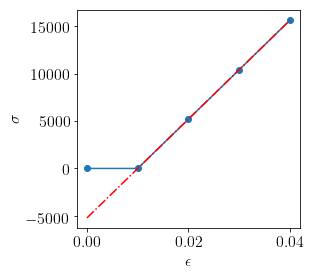

In [125]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
#ax2 = ax.twinx()
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\sigma$',fontsize=16)
ax.tick_params(labelsize=16)
#ax.set_yscale('log')
#ax.set_ylim(1e6,1e8)
#ax2.tick_params(labelsize=16)
#ax.set_title(fileNamee[:-4])
#
#ax.plot(stress[:,0],stress[:,1],'-')

#--- point corresponding to strain maps
virial = []
mu = []
strain = []
times = coord_atoms_broken.keys()
times.sort()
for itime in times:
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] )
    volume = np.linalg.det( CellVectorOrtho )
    virial += [np.c_[coord_atoms_broken[itime]['c_1[4]']].astype(float).sum() / volume]
    mu += [np.c_[coord_atoms_broken[itime]['c_1[22]']].astype(float).sum() / volume]
    #--- strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    strain += [0.5*dx/l1]

#--- plot stress
ax.plot(2*np.array(strain),np.array(virial),'-o')

#--- fit
coeffs = np.polyfit(2*np.array(strain)[1:],np.array(virial)[1:], 1)
def func(x, m, b):
    return m*x+b


#--- print fit
ax.plot(2*np.array(strain),func(2*np.array(strain), *coeffs),'-.r')

#
#plt.savefig('stressStrain'+'.png',dpi=75,bbox_inches='tight')
plt.show()

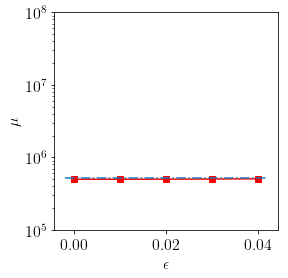

In [126]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
#ax2 = ax.twinx()
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\mu$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_yscale('log')
ax.set_ylim(1e5,1e8)
#ax2.tick_params(labelsize=16)
#ax.set_title(fileNamee[:-4])
#
#ax.plot(stress[:,0],stress[:,1],'-')

#--- plot mu
ax.plot(2*np.array(strain),np.array(mu),'-rs', label='Born')

#--- plot stress
#ax.plot(2*np.array(strain),np.array(virial),'-o')
#ax.plot(2*np.array(strain),np.gradient(virial,2*np.array(strain)),'-o')
ax.plot(ax.axis()[:2],[ coeffs[0], coeffs[0] ],'-.', label='estimate')

#
#plt.savefig('bornModulus.png',dpi=75,bbox_inches='tight')
plt.show()

In [115]:
mu

[636288.5645983985, 636288.5645983985, 636413.321813662]

In [116]:
coeffs[0]

651840.1478789953

In [72]:
mean = coord_atoms_broken[itime]['c_1[22]'].astype(float).mean()
std = coord_atoms_broken[itime]['c_1[22]'].astype(float).std()
'%e'%(mean-2*std)

'-5.744436e+09'